In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch
import cv2
import os
import numpy as np
import torch.nn.functional as F 
from sklearn.metrics import roc_auc_score
import omegaconf
import matplotlib.pylab as plt


In [3]:
cd ..

/home/users/akshay.v/qxr_training


In [4]:
pwd

'/home/users/akshay.v/qxr_training'

In [7]:

df_model = pd.read_csv("/home/users/akshay.v/qxr_training/checkpoint/results/CXRSupHernia/effv2m_hernia_seg/model_496-epoch=31-val_hiatal_hernia_default_qIOU=0.985/model_496-epoch=31-val_hiatal_hernia_default_qIOU=0.985.csv") 

In [8]:
hernia_images = df_model[df_model["hiatal_hernia"]==1].index.values 
roc_auc = roc_auc_score(df_model["hiatal_hernia_target"], df_model["hiatal_hernia"])
print("ROC AUC:", roc_auc)


ROC AUC: 0.9797241788130273


In [9]:
"""
this is how the args are stored
args_string = omegaconf.OmegaConf.create(args)
args_final = omegaconf.OmegaConf.to_container(args_string ,resolve=True)
"""

'\nthis is how the args are stored\nargs_string = omegaconf.OmegaConf.create(args)\nargs_final = omegaconf.OmegaConf.to_container(args_string ,resolve=True)\n'

In [25]:
with torch.no_grad():
    out = model(torch.Tensor(image.unsqueeze(0)))

In [2]:
import torch

# Specify the path to the TorchScript file
#model_path = "/fast_data_e2e_1/janhavi/cxr_models/torchscript_traces/ensembled/gpu_models/v4_adult_tb_cuda.ts"
model_path = "/fast_data_e2e_1/janhavi/cxr_models/torchscript_traces/ensembled/gpu_models/v4_adult_tb_cuda.ts"
# Load the TorchScript model
model = torch.jit.load(model_path)

# If you have a GPU available, move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully.")

Model loaded successfully.


In [4]:
import os

In [16]:
import cv2
im = cv2.imread("/fast_data_2d_3/cxr_data/testing/tb_data/filtered_pngs/chai.26e82289-329c2163-067c015f-74ae4eeb-e01baeca_original_1.2.392.200036.9125.4.0.3374613136.50387060.2688445463.png", 0)

In [17]:
from tqdm import tqdm
import numpy as np
import cv2
def read_image_and_resize_from_path(im_size, path):
    try:
        im = cv2.imread(path, 0)
        if (im is None) or im.size == 0:
            raise RuntimeError("image array is either none or image.size is 0")

        im_resized = cv2.resize(im, (im_size, im_size))
        return im_resized
    except Exception as e:
        print(f"error reading image from {path}, the error is {e}")
        return np.zeros((100, 100))
    
png_data = os.listdir("/fast_data_2d_3/cxr_data/testing/tb_data/filtered_pngs/")
output = {'Patient ID':[],'adult_tb': []}
for file in tqdm(png_data):
    print(file)
    path = f'{"/fast_data_2d_3/cxr_data/testing/tb_data/filtered_pngs/"}{file}'
    print(path)
    img = read_image_and_resize_from_path(1024 , path)
    image = torch.Tensor(img).unsqueeze(0).unsqueeze(0).cuda()
    print(image.shape)
    with torch.no_grad():
        out = model(image)
    output['Patient ID'].append(file.split("_")[-1][:-4])
    output['adult_tb'].append(out[0]['adult_tb'].item())
    
    break

  0%|          | 0/1484 [00:00<?, ?it/s]

chai.26e82289-329c2163-067c015f-74ae4eeb-e01baeca_original_1.2.392.200036.9125.4.0.3374613136.50387060.2688445463.png
/fast_data_2d_3/cxr_data/testing/tb_data/filtered_pngs/chai.26e82289-329c2163-067c015f-74ae4eeb-e01baeca_original_1.2.392.200036.9125.4.0.3374613136.50387060.2688445463.png
torch.Size([1, 1, 1024, 1024])


  0%|          | 0/1484 [00:01<?, ?it/s]


In [19]:
out[1]['adult_tb'].shape

torch.Size([1, 1024, 1024])

In [25]:
.shape

(1, 1024, 1024)

In [45]:
out[2]['age'].item()

11.07174301147461

In [27]:
seg = out[1]['adult_tb'].cpu().numpy()

In [31]:
seg.shape

(1, 1024, 1024)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [37]:
from cv2 import imwrite
from numpy import uint8
filename = os.path.join("/home/users/akshay.v/qxr_training/notebooks/", "check.png")
imwrite(filename, (seg[0]*(seg[0]>=0.4) * 255).astype(uint8))

True

In [78]:
data = pd.DataFrame(output)

In [79]:
data

Patient ID  adult_tb
0     CNZ00052712312195-23  0.009567
1                      001  0.007976
2                    35260  0.004347
3                    19631  0.006177
4                    22466  0.006381
...                    ...       ...
1449             69634692A  0.009800
1450                 30587  0.018033
1451                 32467  0.057484
1452                 3626A  0.007016
1453  CNZ00052712315570-23  0.010119

[1454 rows x 2 columns]

In [86]:
png_csv = pd.read_csv("/fast_data_2d_3/cxr_data/testing/tb_data/TB_final_data_filtered.csv")

In [87]:
png_csv

Patient ID TB:Final Diagnosis  adult_tb_target
0        J6883        Tb negative                0
1       DGDL21        Tb positive                1
2       Jp2173        Tb positive                1
3        5590a        Tb positive                1
4        J6083        Tb positive                1
..         ...                ...              ...
764    1330-23        Tb negative                0
765       2247        Tb negative                0
766       2225        Tb negative                0
767        823        Tb negative                0
768        874        Tb positive                1

[769 rows x 3 columns]

In [88]:
data = pd.read_csv("/home/users/akshay.v/qxr_training/notebooks/output.csv")

In [89]:
data

filename  adult_tb_score
0     chai.fd8e5c5a-f492e162-839c8b26-1f588387-29d7d...        0.983945
1     chai.ffd324b4-7b26079b-a35d4bb5-43bb109e-6a063...        0.959636
2     chai.a49d554b-d3e2a92e-af686d95-aa10ba1c-0f86d...        0.973119
3     chai.d9879cd6-be167d70-75d42ebb-72f17dc3-6b841...        0.995302
4     chai.2e50a2da-6e19ea22-fc70902b-51553fb1-5cf1a...        0.935318
...                                                 ...             ...
1449  chai.c8c73c2e-802cc770-d6775b40-040c351d-32519...        0.826170
1450  chai.645c5d64-7f1fbb97-4c13a561-d122f8ee-55d94...        0.975676
1451  chai.230917b8-b9f3d2a9-df72eb54-6e0c6453-53af5...        0.985762
1452  chai.b9b5bffa-b18efad2-4c6ed5f2-08dcb434-19089...        0.963372
1453  chai.ff2cc790-0d10a8fa-4e8eb25c-ac4b4430-216c7...        0.588113

[1454 rows x 2 columns]

In [93]:
png_csv

Patient ID TB:Final Diagnosis  adult_tb_target
0        J6883        Tb negative                0
1       DGDL21        Tb positive                1
2       Jp2173        Tb positive                1
3        5590a        Tb positive                1
4        J6083        Tb positive                1
..         ...                ...              ...
764    1330-23        Tb negative                0
765       2247        Tb negative                0
766       2225        Tb negative                0
767        823        Tb negative                0
768        874        Tb positive                1

[769 rows x 3 columns]

In [94]:
data

filename  adult_tb_score
0     chai.fd8e5c5a-f492e162-839c8b26-1f588387-29d7d...        0.983945
1     chai.ffd324b4-7b26079b-a35d4bb5-43bb109e-6a063...        0.959636
2     chai.a49d554b-d3e2a92e-af686d95-aa10ba1c-0f86d...        0.973119
3     chai.d9879cd6-be167d70-75d42ebb-72f17dc3-6b841...        0.995302
4     chai.2e50a2da-6e19ea22-fc70902b-51553fb1-5cf1a...        0.935318
...                                                 ...             ...
1449  chai.c8c73c2e-802cc770-d6775b40-040c351d-32519...        0.826170
1450  chai.645c5d64-7f1fbb97-4c13a561-d122f8ee-55d94...        0.975676
1451  chai.230917b8-b9f3d2a9-df72eb54-6e0c6453-53af5...        0.985762
1452  chai.b9b5bffa-b18efad2-4c6ed5f2-08dcb434-19089...        0.963372
1453  chai.ff2cc790-0d10a8fa-4e8eb25c-ac4b4430-216c7...        0.588113

[1454 rows x 2 columns]

In [100]:
data

filename  adult_tb_score  \
0     chai.fd8e5c5a-f492e162-839c8b26-1f588387-29d7d...        0.983945   
1     chai.ffd324b4-7b26079b-a35d4bb5-43bb109e-6a063...        0.959636   
2     chai.a49d554b-d3e2a92e-af686d95-aa10ba1c-0f86d...        0.973119   
3     chai.d9879cd6-be167d70-75d42ebb-72f17dc3-6b841...        0.995302   
4     chai.2e50a2da-6e19ea22-fc70902b-51553fb1-5cf1a...        0.935318   
...                                                 ...             ...   
1449  chai.c8c73c2e-802cc770-d6775b40-040c351d-32519...        0.826170   
1450  chai.645c5d64-7f1fbb97-4c13a561-d122f8ee-55d94...        0.975676   
1451  chai.230917b8-b9f3d2a9-df72eb54-6e0c6453-53af5...        0.985762   
1452  chai.b9b5bffa-b18efad2-4c6ed5f2-08dcb434-19089...        0.963372   
1453  chai.ff2cc790-0d10a8fa-4e8eb25c-ac4b4430-216c7...        0.588113   

            Patient ID  
0     CNZ0005271231219  
1                       
2                    3  
3                    1  
4                    2  
...                ...  
1449             69634  
1450                 3  
1451                 3  
1452                 3  
1453  CNZ0005271231557  

[1454 rows x 3 columns]

In [101]:
data["Patient ID"] = [x.split("_")[-1] for x in data["filename"]]

In [102]:
merged_df = png_csv.merge(data, 
                             on='Patient ID', how='inner')

In [103]:
merged_df

Patient ID TB:Final Diagnosis  adult_tb_target  \
0        J6883        Tb negative                0   
1       DGDL21        Tb positive                1   
2       Jp2173        Tb positive                1   
3        5590a        Tb positive                1   
4        J6083        Tb positive                1   
..         ...                ...              ...   
797       2247        Tb negative                0   
798       2247        Tb negative                0   
799       2225        Tb negative                0   
800        823        Tb negative                0   
801        874        Tb positive                1   

                                              filename  adult_tb_score  
0    chai.69ec881c-0e915519-6dbfc2f1-93501fbf-20265...        0.901678  
1    chai.f4767100-b9fe292f-004acfe0-c229d321-b8899...        0.978642  
2    chai.b6bac246-b722a781-ee49e2c3-dd9dd97e-48df8...        0.461594  
3    chai.0eb42176-af7ad73e-42594e01-2f99e4ab-f976e...        0.991496  
4    chai.5e05584e-c7bc1c4f-1584376b-d48688a8-fbf85...        0.975660  
..                                                 ...             ...  
797  chai.74b0f15f-07eaf943-a4153cb6-132c8bcf-d91c1...        0.092211  
798  chai.b3b4e954-43f4cb53-d7fe0ece-7e1228a1-70750...        0.971743  
799  chai.085c9ed2-b62d0f8e-eff26858-5d9e808f-b935f...        0.861816  
800  chai.144e9779-d82e675a-de9ad627-f04abb72-1b549...        0.773178  
801  chai.5847a280-723cad9a-8039e154-3e3ff63d-a58f9...        0.879715  

[802 rows x 5 columns]

In [104]:
merged_df_no_duplicates_last = merged_df.drop_duplicates(subset='Patient ID', keep='last')
print("\nDataFrame after removing duplicates (keeping the last occurrence):")
print(merged_df_no_duplicates_last)


DataFrame after removing duplicates (keeping the last occurrence):
    Patient ID TB:Final Diagnosis  adult_tb_target  \
0        J6883        Tb negative                0   
1       DGDL21        Tb positive                1   
2       Jp2173        Tb positive                1   
3        5590a        Tb positive                1   
4        J6083        Tb positive                1   
..         ...                ...              ...   
796    1330-23        Tb negative                0   
798       2247        Tb negative                0   
799       2225        Tb negative                0   
800        823        Tb negative                0   
801        874        Tb positive                1   

                                              filename  adult_tb_score  
0    chai.69ec881c-0e915519-6dbfc2f1-93501fbf-20265...        0.901678  
1    chai.f4767100-b9fe292f-004acfe0-c229d321-b8899...        0.978642  
2    chai.b6bac246-b722a781-ee49e2c3-dd9dd97e-48df8...        0.

In [106]:
from sklearn.metrics import roc_curve, auc
import numpy as np

def get_cutoff_youdens_index(fpr, tpr, thresholds) -> float:
    """Calculate and return the threshold value using Youden's Index."""
    j_scores = tpr - fpr
    j_ordered = sorted(zip(j_scores, thresholds))
    return j_ordered[-1][1]

tags_to_check = ["adult_tb"]
# Example data: ground truths and predictions

for tag in tags_to_check:

    print(tag)
    df_tag_results = merged_df_no_duplicates_last[merged_df_no_duplicates_last[f"{tag}_target"]!=-100]
    print(len(df_tag_results))
    y_true = df_tag_results[f"{tag}_target"].values
    y_pred = df_tag_results["adult_tb_score"].values

# Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate AUROC
    auroc = auc(fpr, tpr)

    # Calculate Youden's Index
    youden_index_threshold = get_cutoff_youdens_index(fpr, tpr, thresholds)

    print(f"AUROC: {auroc}")
    print(f"Youden's Index threshold: {youden_index_threshold}")

    specificity = 1 - fpr
    for th in np.arange(0, 1.01, 0.01):
        # Find the closest threshold index
        closest_index = np.argmin(np.abs(thresholds - th))
        sens = tpr[closest_index]
        spec = specificity[closest_index]
        youden_index = sens + spec - 1
        print(f"Threshold: {th:.2f}, Sensitivity: {sens:.2f}, Specificity: {spec:.2f}, Youden Index: {youden_index}")

adult_tb
769
AUROC: 0.8091718515340056
Youden's Index threshold: 0.9717069
Threshold: 0.00, Sensitivity: 1.00, Specificity: 0.00, Youden Index: 0.0
Threshold: 0.01, Sensitivity: 1.00, Specificity: 0.00, Youden Index: 0.0
Threshold: 0.02, Sensitivity: 1.00, Specificity: 0.00, Youden Index: -0.003389830508474523
Threshold: 0.03, Sensitivity: 1.00, Specificity: 0.00, Youden Index: -0.003389830508474523
Threshold: 0.04, Sensitivity: 1.00, Specificity: 0.00, Youden Index: -0.003389830508474523
Threshold: 0.05, Sensitivity: 1.00, Specificity: 0.03, Youden Index: 0.02192662518772792
Threshold: 0.06, Sensitivity: 1.00, Specificity: 0.03, Youden Index: 0.02192662518772792
Threshold: 0.07, Sensitivity: 1.00, Specificity: 0.03, Youden Index: 0.02192662518772792
Threshold: 0.08, Sensitivity: 0.99, Specificity: 0.03, Youden Index: 0.0185367946792534
Threshold: 0.09, Sensitivity: 0.99, Specificity: 0.03, Youden Index: 0.01725666881212895
Threshold: 0.10, Sensitivity: 0.99, Specificity: 0.03, Youden 

In [ ]:
merged_df_no_duplicates_last

In [50]:
merged_df_no_all_duplicates = merged_df[~merged_df['Patient ID'].duplicated(keep=False)]

In [47]:
merged_df

Patient ID TB:Final Diagnosis  adult_tb_target  adult_tb
0        J6883        Tb negative                0  0.488636
1       DGDL21        Tb positive                1  0.153930
2       Jp2173        Tb positive                1  0.285558
3        5590a        Tb positive                1  0.210598
4        J6083        Tb positive                1  0.290852
..         ...                ...              ...       ...
797       2247        Tb negative                0  0.215918
798       2247        Tb negative                0  0.245106
799       2225        Tb negative                0  0.456413
800        823        Tb negative                0  0.418826
801        874        Tb positive                1  0.159415

[802 rows x 4 columns]

In [51]:
merged_df_no_all_duplicates

Patient ID TB:Final Diagnosis  adult_tb_target  adult_tb
0        J6883        Tb negative                0  0.488636
1       DGDL21        Tb positive                1  0.153930
2       Jp2173        Tb positive                1  0.285558
3        5590a        Tb positive                1  0.210598
4        J6083        Tb positive                1  0.290852
..         ...                ...              ...       ...
793    1936-23        Tb positive                1  0.267114
794       2512        Tb negative                0  0.471144
799       2225        Tb negative                0  0.456413
800        823        Tb negative                0  0.418826
801        874        Tb positive                1  0.159415

[739 rows x 4 columns]

In [42]:
data

Patient ID  adult_tb
0     CNZ00052712312195-23  0.333397
1                      001  0.237582
2                    35260  0.276166
3                    19631  0.322642
4                    22466  0.192941
...                    ...       ...
1449             69634692A  0.136502
1450                 30587  0.397894
1451                 32467  0.677821
1452                 3626A  0.246168
1453  CNZ00052712315570-23  0.628384

[1454 rows x 2 columns]

In [18]:
img.shape

(1024, 1024)

In [37]:
out[0]['adult_tb'].item()

0.3333989977836609

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__/cxr_models/model/model_v4_swin.py", line 85, in forward
    main_arch4 = _010.main_arch
    encoder2 = main_arch4.encoder
    _19, _9, _4, _5, = (encoder2).forward(input_, )
                        ~~~~~~~~~~~~~~~~~ <--- HERE
    _23 = (_09).forward(_19, )
    _24 = (_18).forward(_19, )
  File "code/__torch__/torchseg/encoders/timm.py", line 10, in forward
    input_: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
    model = self.model
    _0, _1, _2, _3, = (model).forward(input_, )
                       ~~~~~~~~~~~~~~ <--- HERE
    skip = torch.permute(_0, [0, 3, 1, 2])
    skip0 = torch.permute(_1, [0, 3, 1, 2])
  File "code/__torch__/timm/models/_features.py", line 18, in forward
    layers_0 = self.layers_0
    patch_embed = self.patch_embed
    _0 = (layers_0).forward((patch_embed).forward(input_, ), )
                             ~~~~~~~~~~~~~~~~~~~~ <--- HERE
    _1 = (layers_1).forward(_0, )
    _2 = (layers_2).forward(_1, )
  File "code/__torch__/timm/layers/patch_embed.py", line 12, in forward
    norm = self.norm
    proj = self.proj
    input = torch.permute((proj).forward(input_, ), [0, 2, 3, 1])
                           ~~~~~~~~~~~~~ <--- HERE
    return (norm).forward(input, )
  File "code/__torch__/torch/nn/modules/conv.py", line 12, in forward
    bias = self.bias
    weight = self.weight
    x = torch._convolution(input_, weight, bias, [4, 4], [0, 0], [1, 1], False, [0, 0], 1, False, False, True, True)
        ~~~~~~~~~~~~~~~~~~ <--- HERE
    return x

Traceback of TorchScript, original code (most recent call last):
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/conv.py(456): _conv_forward
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/conv.py(460): forward
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1522): _slow_forward
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1541): _call_impl
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1532): _wrapped_call_impl
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/timm/layers/patch_embed.py(103): forward
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1522): _slow_forward
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1541): _call_impl
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1532): _wrapped_call_impl
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/timm/models/_features.py(299): _collect
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/timm/models/_features.py(345): forward
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1522): _slow_forward
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1541): _call_impl
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1532): _wrapped_call_impl
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torchseg/encoders/timm.py(75): forward
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1522): _slow_forward
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1541): _call_impl
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1532): _wrapped_call_impl
/fast_data_e2e_1/janhavi/cxr_models/cxr_models/model/model_v4_swin.py(230): forward_ens
/fast_data_e2e_1/janhavi/cxr_models/cxr_models/model/model_v4_swin.py(215): forward
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1522): _slow_forward
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1541): _call_impl
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/nn/modules/module.py(1532): _wrapped_call_impl
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/jit/_trace.py(1088): trace_module
/home/users/janhavi.prabhu/miniconda3/envs/qtrain/lib/python3.10/site-packages/torch/jit/_trace.py(820): trace
/fast_data_e2e_1/janhavi/cxr_models/convert_model_v4.py(61): <module>
RuntimeError: Expected 4-dimensional input for 4-dimensional weight [128, 1, 4, 4], but got 3-dimensional input of size [1, 1024, 1024] instead


In [10]:
data = torch.load("/home/users/akshay.v/qxr_training/checkpoint/test_model/test/model_479-epoch=09-val_hiatal_hernia_default_qIOU=0.658.ckpt", map_location='cuda:0')
args_load = data["args"]
model_string = data["model_str"]
sd = data["state_dict"]

In [11]:
# u need to load the arguments like this to infer it
args = omegaconf.OmegaConf.create(args_load)

In [12]:
"""ConnectionAbortedError
cleaned_lines = [line for line in model_string.splitlines() if "cxr_training" not in line]# Joining the cleaned lines to form the cleaned string
cleaned_lines = "\n".join(cleaned_lines)
cleaned_lines = cleaned_lines.replace("model = multihead_module.MultiHead(smp_arch, args)", 
                                      "model = MultiHead(smp_arch, args)")




# Saving the cleaned string to a text file again
with open("/home/users/akshay.v/qxr_training/notebooks/model_load.py", 'w') as f:
    f.write(cleaned_lines)
"""

'ConnectionAbortedError\ncleaned_lines = [line for line in model_string.splitlines() if "cxr_training" not in line]# Joining the cleaned lines to form the cleaned string\ncleaned_lines = "\n".join(cleaned_lines)\ncleaned_lines = cleaned_lines.replace("model = multihead_module.MultiHead(smp_arch, args)", \n                                      "model = MultiHead(smp_arch, args)")\n\n\n\n\n# Saving the cleaned string to a text file again\nwith open("/home/users/akshay.v/qxr_training/notebooks/model_load.py", \'w\') as f:\n    f.write(cleaned_lines)\n'

In [13]:
from cxr_training.nnmodule.models.model_loader import get_model
model = get_model(args)
corrected_state_dict = {k.replace('model.', ''): v for k, v in sd.items()}
corrected_state_dict = {k.replace('main_arch.encoder.', 'main_arch.encoder.model.'): v for k, v in corrected_state_dict.items()}
print(model.load_state_dict(corrected_state_dict, strict=True))

/home/users/akshay.v/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


<All keys matched successfully>


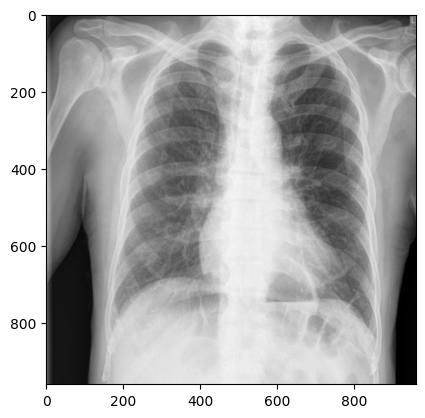

In [14]:

def read_image_and_resize_from_path(im_size, path):
    try:
        im = cv2.imread(path, 0)
        if (im is None) or im.size == 0:
            raise RuntimeError("image array is either none or image.size is 0")

        im_resized = cv2.resize(im, (im_size, im_size))
        return im_resized
    except Exception as e:
        print(f"error reading image from {path}, the error is {e}")
        return np.zeros((100, 100))
file = df_model[df_model["hiatal_hernia_target"] == 1]["id"].values[0]
img = read_image_and_resize_from_path(args.params.im_size , f'{"/cache/fast_data94/ChestXRays/alldata/testing/pngs_1440/"}{file}.png')
plt.imshow(img,cmap="gray")

In [15]:
abnormality = 'hiatal_hernia'

In [16]:
file = df_model[df_model[f"{abnormality}_target"] == 1]["id"].values[0]
img1 = read_image_and_resize_from_path(args.params.im_size , f"/cache/fast_data_nas6/cxr/cxr_data/test_annotations/{abnormality}/{file}.png")
img = read_image_and_resize_from_path(args.params.im_size , f"/cache/fast_data94/ChestXRays/alldata/testing/pngs_1440/{file}.png")


In [17]:
img1 = read_image_and_resize_from_path(args.params.im_size ,  f"/cache/fast_data_nas6/cxr/cxr_data/test_annotations/{abnormality}/{file}.png")

In [18]:
img.shape

(960, 960)

In [19]:
image_tensor = torch.from_numpy(img/255).unsqueeze(0).unsqueeze(0)
print(image_tensor.shape) 

torch.Size([1, 1, 960, 960])


In [20]:
device_no = 1
model = model.cuda(device_no)

In [21]:
model.eval()
with torch.no_grad():
    output = model(image_tensor.cuda(device_no).float())
    print(output)
    soft = F.softmax(output['classification_out'][f'{abnormality}'], dim=1)
    print(soft)

{'classification_out': {'hiatal_hernia': tensor([[-0.0510, -0.3357]], device='cuda:1')}, 'segmentation_out': {'hiatal_hernia': tensor([[[[ 1.7160,  1.9623,  2.2087,  ...,  4.1612,  3.7953,  3.4295],
          [ 1.9786,  2.2886,  2.5987,  ...,  5.0946,  4.6111,  4.1275],
          [ 2.2412,  2.6149,  2.9886,  ...,  6.0281,  5.4268,  4.8255],
          ...,
          [ 1.0747,  1.2588,  1.4429,  ...,  2.5809,  2.2330,  1.8851],
          [ 0.9540,  1.1028,  1.2515,  ...,  2.2182,  1.9365,  1.6549],
          [ 0.8334,  0.9468,  1.0602,  ...,  1.8554,  1.6401,  1.4248]],

         [[-1.8794, -2.1310, -2.3825,  ..., -4.0406, -3.6894, -3.3383],
          [-2.1670, -2.5008, -2.8347,  ..., -5.1525, -4.7076, -4.2627],
          [-2.4546, -2.8707, -3.2868,  ..., -6.2643, -5.7257, -5.1871],
          ...,
          [-1.1288, -1.3355, -1.5421,  ..., -2.5970, -2.2602, -1.9235],
          [-1.0513, -1.2171, -1.3828,  ..., -2.1996, -1.9188, -1.6379],
          [-0.9738, -1.0986, -1.2235,  ..., -1.80

In [22]:

class GradCAMpp:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook the gradients and activations
        self.hooks = []
        self.hooks.append(self.target_layer.register_forward_hook(self.save_output))
        self.hooks.append(self.target_layer.register_backward_hook(self.save_gradient))

    def save_output(self, module, input, output):
        #print(output.shape) #torch.Size([1, 64, 8, 8])
        self.activations = output

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0] #since its a tuple
        #torch.Size([1, 64, 8, 8])
        #print(grad_out[0].shape)

    def __call__(self, input_tensor, target_class='hiatal_hernia'):
        # Reset saved gradients and activations
        self.model.zero_grad()

        # Forward pass
        output = self.model(input_tensor)["classification_out"][target_class]
        #print(output)
        soft = F.softmax(output, dim=1)
        #print(soft)

        # If no specific class is specified, use the class with the highest score
        target_class = np.argmax(soft.data.cpu().numpy())
        # Backward pass
        one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        output.backward(gradient=one_hot_output.to(input_tensor.device))

        # Get hooked gradients and activations
        gradients = self.gradients[0]
        activations = self.activations[0].data.cpu().numpy()
        #print(activations.shape)
        # Grad-CAM++ computation
        
        # different activation maps would have different high value for positive gradients ,so grad cam ==
        # takes that into consideration where it convert all of them to 1 unlike gradcam where it would get hidden 
        alpha_num = gradients
        alpha_denom = gradients**2
        term = alpha_denom * 2 + alpha_num**3
        alpha = alpha_num / (term + 1e-7)
        positive_gradients = torch.where(gradients > 0, gradients, torch.zeros_like(gradients))
        weights = np.sum((positive_gradients * alpha).cpu().numpy(), axis=(1, 2))

        grad_cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, weight in enumerate(weights):
            grad_cam += weight * activations[i, :, :]

        grad_cam = np.maximum(grad_cam, 0)
        grad_cam = cv2.resize(grad_cam, input_tensor.shape[2:][::-1])
        grad_cam = grad_cam - np.min(grad_cam)
        grad_cam = grad_cam / np.max(grad_cam)

        return grad_cam , soft.cpu().detach().numpy()

    def close(self):
        for hook in self.hooks:
            hook.remove()

/home/users/akshay.v/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


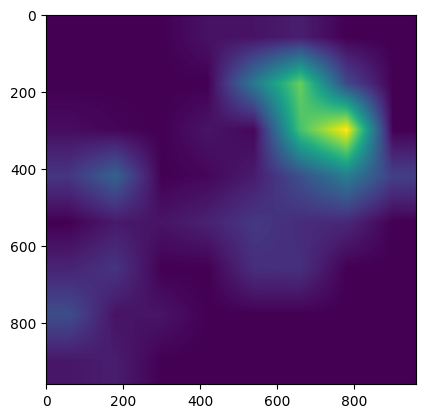

In [23]:
model.eval()
grad_cam_pp = GradCAMpp(model, model.cls_heads[0].lungconv[-4])
cam, soft = grad_cam_pp(image_tensor.cuda(device_no).float(), 'hiatal_hernia')

# Visualize
import matplotlib.pyplot as plt
plt.imshow(cam, cmap='viridis')
plt.show()

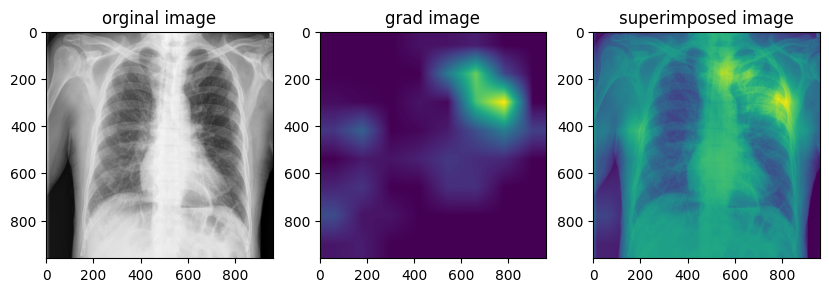

In [24]:
import cv2 


img = img.astype(np.float32)
cam = cam.astype(np.float32)

# If values seem to be in [0, 1] range, scale them to [0, 255]
if img.max() <= 1.0:
    img *= 255.0

if cam.max() <= 1.0:
    cam *= 255.0
        
for i in range(1):
        plt.figure(figsize=(10,10))
        plt.subplot(3,3,1)
        plt.title('orginal image')
        plt.imshow(img,cmap="gray")
        
        plt.subplot(3,3,2)
        plt.title('grad image')
        plt.imshow(cam)
        
        # Superimpose the two images
        alpha = 0.5 # Define an alpha value. 0.5 means both images are given equal weight
        beta = 1-alpha
        superimposed_img = cv2.addWeighted(img, alpha, cam, beta, 0)
        
        plt.subplot(3,3,3)
        plt.title('superimposed image')
        plt.imshow(superimposed_img)
    

In [25]:
generated_seg_path = "/home/users/akshay.v/qxr_training/checkpoint/results/CXRSupHernia/effv2m_hernia_seg/model_496-epoch=31-val_hiatal_hernia_default_qIOU=0.985/hiatal_hernia/"
hernia_images = os.listdir(generated_seg_path)
images = os.listdir(f"/cache/fast_data_nas6/cxr/cxr_data/test_annotations/{abnormality}/")
len(images)

20

20


Processing images: 100%|█████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.46it/s]


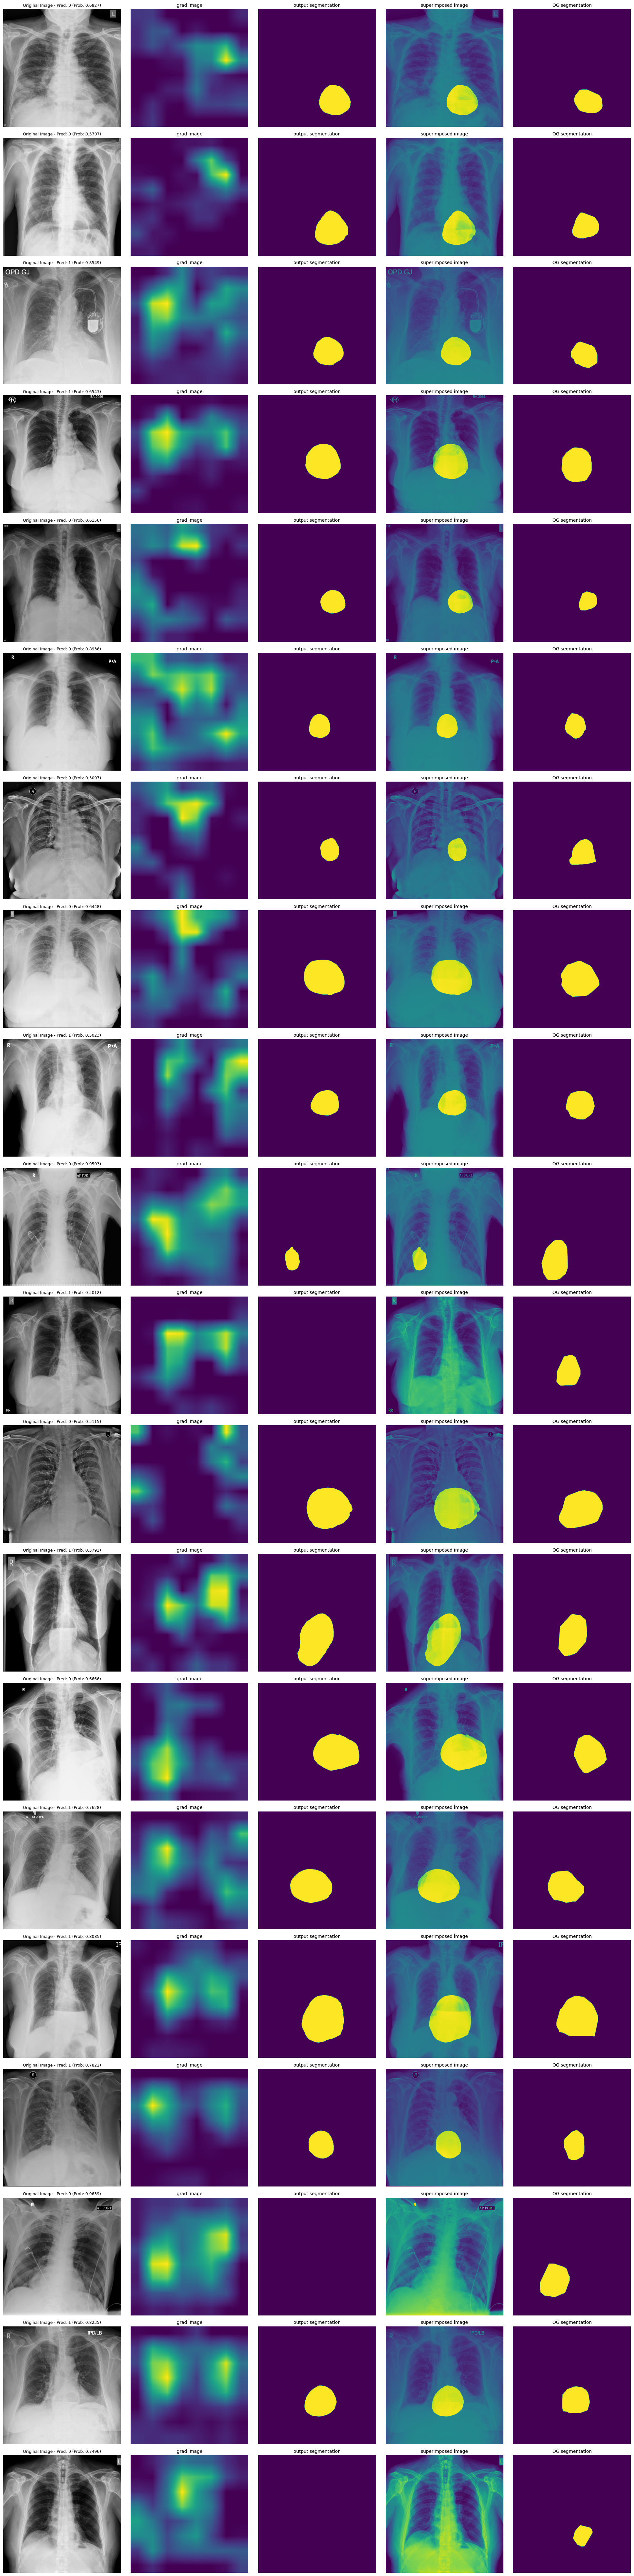

In [26]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
#hernia_images = os.listdir("/home/users/akshay.v/qxr_training/checkpoint/results/CXRSupPnethoranx/effv2m_thorax_16/model_718-epoch=61-val_pneumothorax_default_qIOU=0.465/pneumothorax/")
#hernia_images = random.sample(hernia_images, 15)
num_images = len(hernia_images)
print(num_images)

# Create a grid of subplots
fig, axes = plt.subplots(num_images, 5, figsize=(20, 4*num_images))

model.eval()

for idx, im_file in enumerate(tqdm(hernia_images, desc="Processing images", total=len(hernia_images))):
    img = read_image_and_resize_from_path(args.params.im_size , f'{"/cache/fast_data94/ChestXRays/alldata/testing/pngs_1440/"}{im_file}')
    grad_cam_pp = GradCAMpp(model, model.cls_heads[0].lungconv[-4])
    image_tensor = torch.from_numpy(img/255).unsqueeze(0).unsqueeze(0)
    cam, prob = grad_cam_pp(image_tensor.float().cuda(device=device_no),abnormality)
    predicted_class = np.argmax(prob)
    prediction_value = prob[0][predicted_class].item()

    # Visualize
    img = img.astype(np.float32)/255
    cam = cam.astype(np.float32) 

    axes[idx, 0].imshow(img, cmap="gray")
    axes[idx, 0].set_title(f'Original Image - Pred: {predicted_class} (Prob: {prediction_value:.4f})', fontsize=9)
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(cam)
    axes[idx, 1].set_title('grad image', fontsize=10)
    axes[idx, 1].axis('off')

    output_seg = read_image_and_resize_from_path(args.params.im_size , f'{generated_seg_path}{im_file}')
    axes[idx, 2].imshow((((output_seg/255)>0.00)*1))
    axes[idx, 2].set_title('output segmentation', fontsize=10)
    axes[idx, 2].axis('off')

    axes[idx, 3].imshow((((output_seg/255)>0.00)*1) + img)
    axes[idx, 3].set_title('superimposed image', fontsize=10)
    axes[idx, 3].axis('off')

    og_seg = read_image_and_resize_from_path(args.params.im_size , f"/cache/fast_data_nas6/cxr/cxr_data/test_annotations/{abnormality}/{im_file}")
    axes[idx, 4].imshow(og_seg)
    axes[idx, 4].set_title('OG segmentation', fontsize=10)
    axes[idx, 4].axis('off')

plt.tight_layout()
plt.show()


